In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.autograd.grad_mode import no_grad

In [11]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2),
    nn.Conv2d(in_channels=4, out_channels=12, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2)

)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
fn_loss = nn.CrossEntropyLoss()

In [2]:
train_data = pd.read_csv('../mnist_train.csv')
test_data = pd.read_csv('../mnist_test.csv')

In [3]:
train_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dígito (label):  5


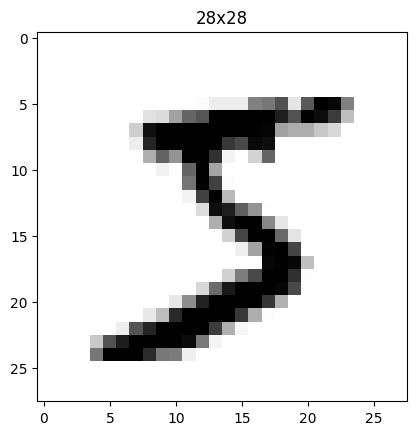

In [4]:
# visualizando os dados de um exemplo (1 linha no txx_data)
index = 0  # qualquer imagem dentre as 60000 de treino
image = train_data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
label = train_data.iloc[index, 0]
print('Dígito (label): ',label)
plt.title('28x28')
plt.imshow(image.reshape(28,28),cmap='binary')

In [5]:
X_train = torch.tensor(train_data.iloc[:,1:].values, dtype=torch.float32)
X_train.shape

torch.Size([60000, 784])

In [6]:
hor66 = torch.ones(60000,66)*100
hor4 = torch.ones(60000,4)*100

Xt = torch.cat((X_train[:,756:],hor66),1)
for ind in range(756,3,-28):
  Xt = torch.cat((X_train[:,ind-28:ind],hor4,Xt),1)
Xt = torch.cat((hor66, Xt),1)

Xt.shape

torch.Size([60000, 1024])

Dígito (label):  5


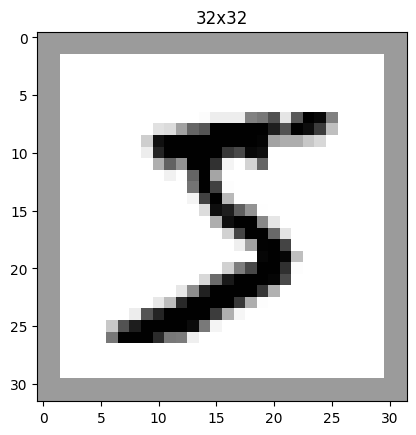

In [7]:
# visualizando os dados de um exemplo (1 linha no txx_data)
index = 0  # qualquer imagem dentre as 60000 de treino
image = Xt[index, :].reshape((32, 32, 1))
label = train_data.iloc[index, 0]
print('Dígito (label): ',label)
plt.title('32x32')
plt.imshow(image.reshape(32,32),cmap='binary')

In [8]:
# ajustando a entrada da RNA (tensores e 32x32)
X_train = torch.tensor(train_data.iloc[:,1:].values, dtype=torch.float32)
X_test = torch.tensor(test_data.iloc[:,1:].values, dtype=torch.float32)
qTrain = X_train.shape[0]
qTest = X_test.shape[0]

# training
hor66 = torch.zeros(qTrain,66)
hor4 = torch.zeros(qTrain,4)
Xtr = torch.cat((X_train[:,756:],hor66),1)
for ind in range(756,3,-28):
  Xtr = torch.cat((X_train[:,ind-28:ind],hor4,Xtr),1)
Xtr = torch.cat((hor66, Xtr),1)

# testing
hor66 = torch.zeros(qTest,66)
hor4 = torch.zeros(qTest,4)
Xts = torch.cat((X_test[:,756:],hor66),1)
for ind in range(756,3,-28):
  Xts = torch.cat((X_test[:,ind-28:ind],hor4,Xts),1)
Xts = torch.cat((hor66, Xts),1)

Xtr =torch.reshape(Xtr,(qTrain,32,32))
Xts =torch.reshape(Xts,(qTest,32,32))

Xtr.shape, Xts.shape

(torch.Size([60000, 32, 32]), torch.Size([10000, 32, 32]))

In [9]:
# separando as saídas (classes)
Ytr = torch.tensor(pd.get_dummies(train_data['label']).values, dtype=torch.float32)
Yts = torch.tensor(pd.get_dummies(test_data['label']).values, dtype=torch.float32)
Ytr.shape, Yts.shape

(torch.Size([60000, 10]), torch.Size([10000, 10]))

In [10]:
# dataloader
batch1 = 5000
batch2 = 5000
trainDataset = DataLoader(list(zip(Xtr,Ytr)), batch_size=batch1, shuffle=True)
testDataset = DataLoader(list(zip(Xts,Yts)), batch_size=batch2, shuffle=False)

# listas para registro do treinamento
trainLoss = []
testLoss = []
trainPredictOK = []
testPredictOK = []

n_epocas = 50

In [12]:
# treinamento

for epoca in range(n_epocas):
  trainOK = 0
  testOK = 0

  for (X_train, y_train) in trainDataset:
    X_train = torch.reshape(X_train,(batch1,1,32,32))
    y_pred = model(X_train)
    loss = fn_loss(y_pred, y_train)

    predicted = torch.max(y_pred.data,1)[1]
    batchOK = (predicted == torch.max(y_train,1)[1]).sum()
    trainOK = trainOK + batchOK

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  trainLoss.append(loss.item())
  trainPredictOK.append(trainOK/qTrain)

  with torch.no_grad():
    for (X_test, y_test) in testDataset:
      X_test = torch.reshape(X_test,(batch2,1,32,32))
      y_pred = model(X_test)
      predicted2 = torch.max(y_pred.data, 1)[1]
      batchOK = (predicted2 == torch.max(y_test,1)[1]).sum()
      testOK = testOK + batchOK

    loss2 = fn_loss(y_pred, y_test)
    testLoss.append(loss2.item())
    testPredictOK.append(testOK/qTest)

  if (epoca == 0):
    print('Época\tTrainLoss\tTestLoss\tAccurTrain\tAccurTest')
    print(f'{epoca} \t {trainLoss[-1]:.4f}\t\t {testLoss[-1]:.4f}\t\t{trainPredictOK[-1]:.4f}\t\t{testPredictOK[-1]:.4f}')
  elif (epoca%5 == 0):
    print(f'{epoca} \t {trainLoss[-1]:.4f}\t\t {testLoss[-1]:.4f}\t\t{trainPredictOK[-1]:.4f}\t\t{testPredictOK[-1]:.4f}')


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 2